## Домашнее задание 4

Задача тематическое моделирование

продолжаем исследование датасета с твитами

Скачиваем датасет (источник): положительные, отрицательные.

рабочие ссылки с твитами

https://disk.yandex.ru/i/v5HM-ENiGXZVpQ

https://disk.yandex.ru/i/koR5eMCToCZS2Q

как альтернатива можно скачать данные из Роспотребнадзора 

https://zpp.rospotrebnadzor.ru/Forum/Appeals

для этого берём ноутбук `parse_rospotrebnadzor.ipynb`

устанавливаем количество скачанных страниц больше не 50-сят хотябы 500 и для анализа берём только вопросы так как ответы есть не всегда

что надо сделать:

1. объединить в одну выборку (это только для твитов), для роспотребнадзора сформировать датасет из вопросов
2. провести исследование и выявить тематики о которых говорят в твитах (для твитов), а для роспотребнадзора так же выявить тематики о которых люди пишут проанализировать
3. сделать визуализацию кластеров тематик
4. проинтерпритировать получившиеся тематики

## Решение

Импортируем и установим базовые библиотеки, необходимые для решения поставленной задачи.

In [103]:
!pip install natasha pyLDAvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [104]:
import re
import nltk
import pyLDAvis
import gensim
import numpy as np
import pandas as pd
import pyLDAvis.gensim_models as gensimvis
import warnings
import matplotlib.pyplot as plt
%matplotlib inline

from nltk.corpus import stopwords
from pymorphy2 import MorphAnalyzer
from tqdm.notebook import tqdm
from multiprocessing import Pool
from gensim.models import *
from gensim import corpora

warnings.filterwarnings("ignore", category=DeprecationWarning)
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Воспользуемся данными предварительно загруженными с сайтами Роспотребнадзора по инструкции, приложенной к лекции, и сохранненными для удобства в файл. В качестве датасета я взял вопросы-ответы с первых 599 страниц на сайте с обращениями.

In [105]:
df = pd.read_csv('/content/rospotrebnadzor.csv', index_col=0)
df.sample(5)

,questions,answers
1091,"Добрый день \r\nСегодня 25,04.2022 в 16,00 авт...","Уважаемая Kristina!\r\nОбращаем Ваше внимание,..."
2819,Здравствуйте! 26.01.2020г.мною был куплен тур ...,Добрый день. Вам необходимо обратиться в Управ...
1677,Если иностранный гражданин переболел ковидом.и...,"Уважаемый Валентин! Сообщаем, что постановлени..."
2722,05.12.21 был сделан заказ с сайта https://food...,Уважаемая Юлия Шурчкова!\r\nРаздел «Виртуальна...
1668,Почему на пр лавках отсутствует сахарный песок?,Управление Роспотребнадзора по Удмуртской Респ...


Для целей данного задания будем работать только с вопросами. Произведем предобработку данных.

In [106]:
morph = MorphAnalyzer()
stopwords_list = stopwords.words('russian')
stopwords_list.append('это')
stopwords_list.append('здравствуйте')
stopwords_list.append('добрый')
stopwords_list.append('день')
stopwords_list.append('год')

In [107]:
words_regex = re.compile('\w+')

def find_words(text, regex = words_regex):
    tokens =  regex.findall(text.lower())
    return [w for w in tokens if w.isalpha() and len(w) >= 3]

def lemmatize(words, lemmer = morph, stopwords = stopwords_list):
    lemmas = [lemmer.parse(w)[0].normal_form for w in words]
    return [w for w in lemmas if not w in stopwords and w.isalpha()]

def preprocess(text):
    return (lemmatize(find_words(text)))

In [108]:
df['preprocessed_questions'] = df['questions'].apply(preprocess)
df.head()

,questions,answers,preprocessed_questions
0,Помогите пожалуйста в расторжении договора с П...,Уважаемый Игорь!\r\nВ соответствии с пунктом 4...,"[помочь, пожалуйста, расторжение, договор, пао..."
1,"Жалоба на детскую поликлинику номер 15, по адр...","Ксения!\r\n Вопросы, поставленные в Ва...","[жалоба, детский, поликлиника, номер, адрес, с..."
2,Я врач-инфекционист хочу открыть инфекционный ...,"Здравствуйте, Елена! При осуществлении медицин...","[врач, инфекционист, хотеть, открыть, инфекцио..."
3,"Возле подъезда лежат мертвые птицы, УК Наш Гор...","Ольга,добрый день! В Московской области с таки...","[возле, подъезд, лежать, мёртвый, птица, наш, ..."
4,Прошу провести проверку по факту размещения ра...,"Вячеслав,добрый день! Вам необходимо перенапра...","[просить, провести, проверка, факт, размещение..."


Создадим словарь с фильтрацией выбросов и векторизуем документы.

In [119]:
dictionary = corpora.Dictionary(df['preprocessed_questions'])

dictionary.filter_extremes(no_below=2, no_above=0.85, keep_n=None)
dictionary.save('rpn.dict')

In [120]:
corpus = [dictionary.doc2bow(question) for question in df['preprocessed_questions']]
corpora.MmCorpus.serialize('rpn.model', corpus) 

Теперь обучим модель и посмотрим на оценки качества.

In [121]:
%time 
lda = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=15, 
                        chunksize=100, update_every=1, passes=2)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


In [122]:
print('Персплексия: ', np.exp(lda.log_perplexity(corpus)))

Персплексия:  0.0003830073954866006


In [123]:
coherence_model_lda = CoherenceModel(model=lda, texts=df['preprocessed_questions'], dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Средняя когерентность: ', coherence_lda)

Средняя когерентность:  0.37002522446891395


Посмотрим как меняется оценка когерентности в зависимости от количества выделяемых тем.

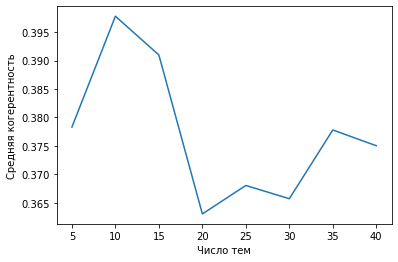

In [124]:
topics_list = [5, 10, 15, 20, 25, 30, 35, 40]
coherences = []

for num in topics_list:
    lda = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=num, 
                            chunksize=100, update_every=1, passes=2)
    coherences.append(CoherenceModel(model=lda, 
                                     texts=df['preprocessed_questions'], 
                                     dictionary=dictionary, 
                                     coherence='c_v').get_coherence())

plt.plot(topics_list, coherences)
plt.xlabel("Число тем")
plt.ylabel("Средняя когерентность")
plt.show()

Обучим окончательную модель и посмотрим на слова, определяющие темы.

In [125]:
lda = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=10, 
                        chunksize=100, update_every=1, passes=2)

lda.show_topics(num_topics=10, num_words=10, formatted=True)

[(0,
  '0.032*"возврат" + 0.027*"товар" + 0.021*"деньга" + 0.021*"вернуть" + 0.020*"средство" + 0.013*"денежный" + 0.012*"срок" + 0.012*"мочь" + 0.011*"магазин" + 0.010*"написать"'),
 (1,
  '0.084*"магазин" + 0.047*"товар" + 0.025*"продавец" + 0.013*"купить" + 0.012*"данный" + 0.012*"посылка" + 0.011*"продажа" + 0.009*"адрес" + 0.009*"покупка" + 0.009*"покупатель"'),
 (2,
  '0.047*"заказ" + 0.025*"товар" + 0.017*"доставка" + 0.012*"оплатить" + 0.012*"сайт" + 0.011*"интернет" + 0.011*"магазин" + 0.009*"поддержка" + 0.008*"сделать" + 0.008*"служба"'),
 (3,
  '0.018*"номер" + 0.015*"компания" + 0.015*"руб" + 0.014*"карта" + 0.014*"банк" + 0.012*"счёт" + 0.011*"оплата" + 0.011*"телефон" + 0.010*"который" + 0.010*"сайт"'),
 (4,
  '0.029*"ребёнок" + 0.018*"тест" + 0.014*"сертификат" + 0.014*"дом" + 0.014*"квартира" + 0.012*"маска" + 0.010*"детский" + 0.010*"родитель" + 0.009*"помещение" + 0.008*"сад"'),
 (5,
  '0.018*"акт" + 0.012*"пцр" + 0.012*"просить" + 0.012*"петербург" + 0.011*"санкт" +

Как видим некоторые темы удалось выделить очень хорошо и их легко интерпретировать.

Например, очевидно, что первая тема (id 0) связана с возвратами товаров. Вторая тема - с покупкой/продажей товаров в магазинах и их доставкой. Тема 3 (id 2) определяется словами, описывающими процесс заказа товаров на сайте в интернете и сопутствующими проблемами. Тема 4 (id 3) связана с банковскими вопросами. Тема 5 судя по всему связана с соблюдением ковидных ограничений в различных местах. Тема 7 - с ремонтными работами.

Тем не менее некоторые темы интерпретировать довольно проблематично. Это хорошо видно, на мой взгляд, на примере темы 8 (id 7), наиболее важные слова не дают общего представления о теме.

Визуализируем результаты модели.

In [126]:
%time
vis_data = gensimvis.prepare(lda, corpus, dictionary)
pyLDAvis.display(vis_data)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.82 µs


/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


Как видим некоторые тематики довольно сильно пересекаются (например, 1 и 2 или 9 и 10 на приведенном выше изображении). С другой стороны видны также и темы, которые удалось выделить довольно однозначно и они не пересекаются с другими.

In [131]:
pyLDAvis.save_html(vis_data, '/content/LDAvis.html')